# Exercise Set 2

Required python packages

In [1]:
# Visualization
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, LogNorm, LinearSegmentedColormap
import matplotlib.colors as mcolors
from IPython.display import Image, display

# Utility & Logging
import os
import time
import sys
import logbook
from logbook import Logger, StreamHandler, FileHandler, DEBUG, INFO, WARNING, ERROR, NOTSET
from tqdm.notebook import tqdm

# Core numerical processing
import numpy as np
from numba import jit, prange
import random

In [2]:
np.random.seed(42)

DATA_PATH = 'data/ex2'
MEDIA_PATH = 'media/ex2'
LOG_PATH = 'log'
ANIM_BACKEND = 'ffmpeg'
os.makedirs(DATA_PATH, exist_ok=True)
os.makedirs(MEDIA_PATH, exist_ok=True)
os.makedirs(LOG_PATH, exist_ok=True)

LOAD_CACHED_FILES_IF_AVAILABLE = True

log = Logger('Set 2 Logger')
fh = FileHandler(f'{LOG_PATH}/ex2_1_1.log', mode='w', level=INFO, bubble=True)
fh.push_application()

Check for CUDA availability for GPU compute

In [3]:
from numba import cuda

CUDA = False

try:
    CUDA = cuda.detect()
    log.info('CUDA is available.')
except ImportError:
    log.info('CUDA is not available. Uses CPU for computations instead.')

# 2.1.1 - Diffusion-Limited Aggregation with SOR 

Core functionality for solving Laplace equation

In [4]:
def sor_basic(c: np.ndarray, omega: float, obj: np.ndarray, epsilon=1e-6, max_iterations=10_000):
    '''Solves the Laplace equation using the simple iterative (inefficient) Successive Over-Relaxation (SOR) method introduced in Set 1'''
    converged = False
    Nx = c.shape[0]  # Assume 2D square lattice

    for n in range(max_iterations):
        c_old = c.copy()  # Copy the grid for convergence check

        for i in range(0, Nx):
            for j in range(0, Nx-1):  # exclude y=Nx source
                if obj[i, j] == 0:
                    if j == 0:
                        c[i, j] = max((1-omega)*c[i, j] + omega/3 * \
                            (c[(i+1) % Nx, j] + c[i-1, j] + c[i, j+1]), 0)
                    else:
                        c[i, j] = max((1-omega)*c[i, j] + omega*0.25 * \
                            (c[(i+1) % Nx, j] + c[i-1, j] +
                                c[i, j+1] + c[i, j-1]), 0)
                else:
                    c[i, j] = 0.0

        # Check for convergence
        if np.max(np.abs(c - c_old)) < epsilon:
            converged = True
            # log.debug(f'Converged after {n} iterations using omega={omega}.')
            break

    return c, n, converged

@jit(nopython=True, parallel=True)
def sor_parallel(c: np.ndarray, omega: float, obj: np.ndarray, epsilon=1e-6, max_iterations=10_000):
    '''Solves the Laplace equation using the red-black parallel Successive Over-Relaxation (SOR) method introduced in Set 1'''
    converged = False
    Nx = c.shape[0]  # Assume 2D square lattice

    for n in range(max_iterations):
        c_old = c.copy()  # Copy the grid for convergence check

        # Red points
        for i in prange(0, Nx):
            for j in range(0, Nx-1): # exclude y=Nx source
                if (i + j) % 2 == 0:
                    if obj[i, j] == 0:
                        # note use of negative indices and modulo for boundary cases
                        # max to ensure non-negative concentrations
                        if j == 0: # j-1 excluded
                            c[i, j] = max((1-omega)*c[i, j] + omega/3 * \
                                (c[(i+1) % Nx, j] + c[i-1, j] + c[i, j+1]), 0)
                        else:
                            c[i, j] = max((1-omega)*c[i, j] + omega*0.25 * \
                                (c[(i+1) % Nx, j] + c[i-1, j] +
                                 c[i, j+1] + c[i, j-1]), 0)
                    else:
                        c[i, j] = 0.0

        # Black points | same comments as above
        for i in prange(0, Nx):
            for j in range(0, Nx-1):
                if (i + j) % 2 == 1:
                    if obj[i, j] == 0:
                        if j == 0:
                            c[i, j] = max((1-omega)*c[i, j] + omega/3 * \
                                (c[(i+1) % Nx, j] + c[i-1, j] + c[i, j+1]), 0)
                        else:
                            c[i, j] = max((1-omega)*c[i, j] + omega*0.25 * \
                                (c[(i+1) % Nx, j] + c[i-1, j] +
                                 c[i, j+1] + c[i, j-1]), 0)
                    else:
                        c[i, j] = 0.0

        # Check for convergence
        if np.max(np.abs(c - c_old)) < epsilon:
            converged = True
            # log.debug(f'Converged after {n} iterations using omega={omega}.')
            break

    return c, n, converged

Visualization utility

In [5]:
def plot_concentration(c, title, filename, save=True):
    '''Plots the concentration matrix using default heatmap.'''
    plt.figure(figsize=(5, 4), layout='tight')
    plt.imshow(np.rot90(c, 3), origin='lower')
    plt.colorbar(label='Concentration')
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    if save:
        plt.savefig(f'{MEDIA_PATH}/{filename}.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_object(obj, title, filename, save=True):
    '''Plots the object in white on a black background.'''
    plt.figure(figsize=(5, 4), layout='tight')
    plt.imshow(np.rot90(obj, 3), origin='lower', cmap='binary')
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    if save:
        plt.savefig(f'{MEDIA_PATH}/{filename}.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_object_on_concentration(c, obj, title, filename, save=True):
    '''Plots the concentration matrix as background with the object drawn on top.'''
    plt.figure(figsize=(5, 4), layout='tight')
    cmap = plt.get_cmap('viridis')
    img = plt.imshow(np.rot90(c, 3), origin='lower', cmap=cmap)
    plt.colorbar(label='Concentration')

    # Paint object white
    rgba_img = cmap(np.rot90(c, 3))
    rgba_img[np.rot90(obj, 3) == 1, :3] = 1
    plt.imshow(rgba_img, origin='lower')

    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    if save:
        plt.savefig(f'{MEDIA_PATH}/{filename}.png', dpi=300, bbox_inches='tight')
    plt.show()

Test run of SOR implementation

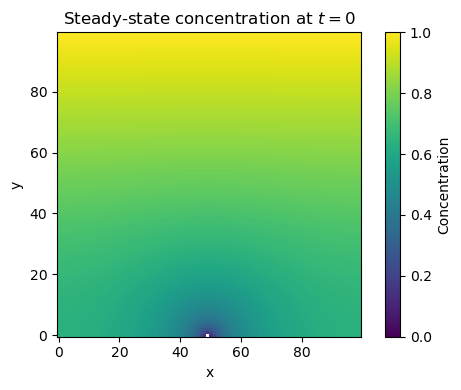

In [6]:
Nx = 100
omega = 1.8

c = np.zeros((Nx, Nx))
c[:, -1] = 1.0
c_init = c.copy()

obj = np.zeros((Nx, Nx), dtype=int)  # growing object
obj[Nx//2, 0] = 1
c[Nx//2, 0] = 0.0

c, sor_iters, converged = sor_parallel(c, omega, obj)
plot_object_on_concentration(c, obj, f'Steady-state concentration at $t=0$', f'initial_concentration_dla')

## Computing performance comparison (iterative vs. parallel)

Compare speed of solving Laplace equation using simple iterative SOR vs. optimized parallel scheme

In [7]:
gridsizes = np.insert(np.logspace(1, 3, 15, base=10, dtype=int), 0, 5)
times = np.zeros((len(gridsizes), 2))
sor_iters = np.zeros((len(gridsizes), 2))

if LOAD_CACHED_FILES_IF_AVAILABLE and os.path.exists(f'{DATA_PATH}/comparison_times.csv') and os.path.exists(f'{DATA_PATH}/comparison_sor_iters.csv'):
    times = np.loadtxt(f'{DATA_PATH}/comparison_times.csv', delimiter=',', skiprows=1)
    sor_iters = np.loadtxt(f'{DATA_PATH}/comparison_sor_iters.csv', delimiter=',', skiprows=1)
else:
    for s, sor_solver in tqdm(enumerate([sor_basic, sor_parallel]), total=2, desc='Testing solvers', leave=False, unit='solver'):
        for i, Nx in tqdm(enumerate(gridsizes), total=len(gridsizes), desc=f'Simulating grid sizes', leave=False, unit='sim'):
            if sor_solver is sor_basic and Nx > 200:  # Skip basic solver for grid sizes over 200, takes too long
                times[i, s] = np.nan
                continue

            c = np.zeros((Nx, Nx))
            c[:, -1] = 1.0
            
            obj = np.zeros((Nx, Nx), dtype=int)  # growing object
            obj[Nx//2, 0] = 1
            c[Nx//2, 0] = 0.0

            start = time.time()
            c, sor_iters, converged = sor_solver(c, omega, obj)
            end = time.time()

            sor_iters[i, s] = sor_iters
            times[i, s] = end - start

    np.savetxt(f'{DATA_PATH}/comparison_times.csv', np.asarray(times), delimiter=',', header='basic,parallel', comments='')
    np.savetxt(f'{DATA_PATH}/comparison_sor_iters.csv', np.asarray(sor_iters), delimiter=',', header='basic,parallel', comments='')

Visualize results

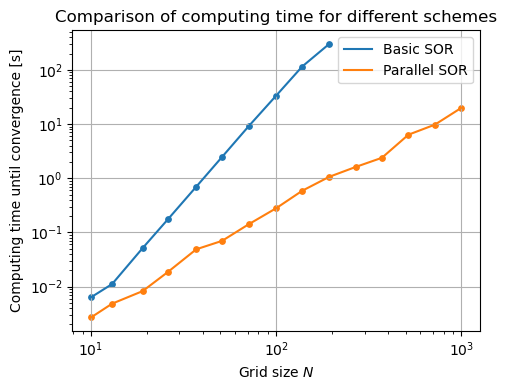

In [8]:
plt.figure(figsize=(5, 4), layout='tight')
# Skip first run as it has side effects of compilation for `sor_parallel`
plt.plot(gridsizes[1:], times[1:, 0], label='Basic SOR', color='tab:blue')
plt.scatter(gridsizes[1:], times[1:, 0], color='tab:blue', s=15)
plt.plot(gridsizes[1:], times[1:, 1], label='Parallel SOR', color='tab:orange')
plt.scatter(gridsizes[1:], times[1:, 1], color='tab:orange', s=15)
plt.xlabel('Grid size $N$')
plt.ylabel('Computing time until convergence [s]')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.title('Comparison of computing time for different schemes')
plt.savefig(f'{MEDIA_PATH}/comparison_by_time.png', dpi=300, bbox_inches='tight')
plt.show()

## Diffusion-Limited Aggregation

Utility functionality to set up experiments and reusable components of the DLA function

In [ ]:
def setup_concentration_matrix(Nx, seed_pos_idx, init_optimize):
    c = np.zeros((Nx, Nx))
    c[:, -1] = 1  # top is source

    # Optimization: initial guess for stable concentration profile using analytical solution
    if init_optimize:
        y = np.linspace(0, 1, Nx)
        for i, y_i in enumerate(y):
            c[:, i] = y_i

    c[*seed_pos_idx] = 0

    return c


def get_seed_position(Nx, seed_pos: str):
    arg_list = seed_pos.lower().split(' ')

    if len(arg_list) == 0 or len(arg_list) == 1 and arg_list[0] != 'center':
        raise ValueError('Invalid seed position. Please provide positioning for both x and y coordinates or use "center".')
    elif len(arg_list) == 1 and arg_list[0] == 'center':
        return (Nx//2, Nx//2)

    seed_pos_h_dict = {
        'left': 0,
        'center': Nx//2,
        'right': Nx-1
    }

    x = seed_pos_h_dict.get(arg_list[-1], -1)
        
    seed_pos_v_dict = {
        'lower': 0,
        'center': Nx//2,
        'upper': Nx-1
    }

    y = seed_pos_v_dict.get(arg_list[0], -1)

    if x == -1 or y == -1:
        raise ValueError('Invalid seed position. Please provide valid positioning for both x and y coordinates or use "center".')

    return (x, y)

def add_growth_candidates(growth_candidates: set, obj: np.ndarray, new_idx: tuple, Nx: int, skip_removal=False):
    '''Utility functionality to add the growth candidates to the list of candidates, remembering previous states and minimize re-checking. Efficient solution.'''
    i, j = new_idx
    # Remove newly added growth object
    if not skip_removal:
        growth_candidates.remove(new_idx)

    # Add von Neumann neighbors of the object
    if obj[(i-1) % Nx, j] == 0:
        growth_candidates.add(((i-1 % Nx), j))
    if obj[(i+1) % Nx, j] == 0:
        growth_candidates.add(((i+1) % Nx, j))
    if j > 0 and obj[i, j-1] == 0:
        growth_candidates.add((i, j-1))
    if j < Nx-1 and obj[i, j+1] == 0:
        growth_candidates.add((i, j+1))

    if len(growth_candidates) == 0:
        log.warning(f'No more growth candidates found.')
    else:
        log.debug(f'Found {len(growth_candidates)} growth candidates.')

    return growth_candidates

def get_candidates_bruteforce(obj):
    '''Utility functionality to get all van Neumann (Manhattan distance = 1) neighbors (growth candidates) of the object.
    Returns a numpy array of the indices of the growth candidates. Inefficient solution.'''
    obj_indices = np.argwhere(obj == 1)
    Nx = obj.shape[0] # assume square
    growth_candidates = set()

    # consider all von Neumann neighbors of the object that aren't the object as candidates
    for i, j in obj_indices:
        if obj[i-1, j] == 0:
            growth_candidates.add((i-1, j))
        if obj[(i+1) % Nx, j] == 0:
            growth_candidates.add(((i+1) % Nx, j))
        if j > 0 and obj[i, j-1] == 0:
            growth_candidates.add((i, j-1))
        if j < Nx-1 and obj[i, j+1] == 0:
            growth_candidates.add((i, j+1))

    if len(growth_candidates) == 0:
        log.warning(f'No more growth candidates found.')
    else:
        log.debug(f'Found {len(growth_candidates)} growth candidates.')

    return np.array(list(growth_candidates))


def get_candidate_probabilities(c, growth_candidates, eta):
    '''Utility functionality to get the probability of growth for each candidate based on its concentration.'''
    candidate_probabilities = np.zeros(len(growth_candidates))

    if eta < 0:
        raise ValueError('Eta must be greater equals zero.')
    elif eta > 2:
        log.warning('Eta is greater than 2. Usually 0 <= eta <= 2.')

    for i, (x, y) in enumerate(growth_candidates):
        candidate_probabilities[i] = c[x, y]**eta

    sum_probabilities = np.sum(candidate_probabilities)

    if np.any(candidate_probabilities < 0):
        log.debug('Negative growth probabilities found. Should be impossible as `soc_parallel` should be preventing this.')
        log.debug(f'Growth candidate matrix:\n{growth_candidates}')
        log.debug(f'Candidate probabilities:\n{candidate_probabilities}')
        raise ValueError('Negative growth probabilities found.')

    if sum_probabilities <= 0:
        raise ValueError(
            'Sum of probabilities is (less than or equal) zero but neighbors were found. Either all neighbors have concentration exactly 0 (unlikely) or there is another issue. Please check the concentration matrix.')
    
    candidate_probabilities /= sum_probabilities

    return candidate_probabilities


def select_best_omega_for_sor(omega_values, epsilon, c_init, seed_pos='lower center', max_iterations=10_000):
    '''Finds the best relaxation parameter omega for SOR'''

    best_omega = 0
    least_iter = max_iterations

    # Growth object
    seed_pos_idx = get_seed_position(Nx, seed_pos)
    obj = np.zeros((Nx, Nx), dtype=int)
    obj[*seed_pos_idx] = 1
    log.debug(f'Number of non-zero object elements after initialization: {np.count_nonzero(obj)}.')

    for omega in tqdm(omega_values):
        c = c_init.copy()
        c, n_iter, converged = sor_parallel(c, omega, obj, epsilon, max_iterations)
        if converged and n_iter < least_iter:
            least_iter = n_iter
            best_omega = omega
            c_converged = c.copy()
        # else:
        #     log.debug(f'Convergence not reached for omega={omega}.')
    if best_omega == 0:
        raise ValueError(f'Unable to converge using provided omega values {omega_values} within {max_iterations} steps. ' + 
                         'Please provide larger omega range and/or maximum iteration count to reach convergence.')
    return c_converged, best_omega, least_iter

Implementation of growth model simulation using `sor_parallel` as Laplace solver

In [9]:
def simulate_dla_growth_model(Nt, Nx=100, max_sor_iter=1_000, omega=1.7, eta=1.0, epsilon=1e-6, seed_pos='lower center', init_optimize=True, show_tqdm=True):
    '''Simulates the Diffusion Limited Aggregation (DLA) growth model using a parallized SOR scheme.
    Returns the concentration matrix, the object matrix and the number of iterations until the end of the simulation.
    '''
    # Growth object
    seed_pos_idx = get_seed_position(Nx, seed_pos)
    c = setup_concentration_matrix(Nx, seed_pos_idx, init_optimize)

    obj = np.zeros((Nx, Nx), dtype=int)
    obj[*seed_pos_idx] = 1
    log.debug(f'Size of object after initialization: {np.count_nonzero(obj)}.')

    growth_candidates = set()
    growth_candidates = add_growth_candidates(growth_candidates, obj=obj, new_idx=seed_pos_idx, Nx=Nx, skip_removal=True)

    times = np.zeros((Nt))
    sor_iters = np.zeros((Nt), dtype=int)

    iterator = tqdm(range(Nt), desc='Simulating DLA run', leave=False) if show_tqdm else range(Nt)
    for iter in iterator:
        start = time.time()
        c, sor_iter, converged = sor_parallel(
            c, omega, obj, epsilon, max_sor_iter)
        end = time.time()

        sor_iters[iter] = sor_iter
        times[iter] = end - start
        
        if not converged:
            raise ValueError(f'SOR convergence for DLA time step {iter} not reached after {sor_iter} iterations. ' + 
                             'Increase `max_iterations` or decrease `epsilon`.')
        else:
            log.debug(f'SOR converged after {sor_iter} iterations.')

        candidate_probabilities = get_candidate_probabilities(
            c, growth_candidates, eta)
        
        list_growth_candidates = list(growth_candidates)
        
        chosen_idx = np.random.choice(len(growth_candidates), p=candidate_probabilities)
        log.debug(f'Chosen index: {chosen_idx} of list with value {list_growth_candidates[chosen_idx]}.')

        selected_candidate_idx = list_growth_candidates[chosen_idx]
        log.debug(f'Selected candidate: {list_growth_candidates[chosen_idx]} with p={candidate_probabilities[chosen_idx]:.3f}.')

        # Update growth_candidates
        growth_candidates = add_growth_candidates(growth_candidates, obj=obj, new_idx=selected_candidate_idx, Nx=Nx)

        obj[*selected_candidate_idx] = 1
        log.debug(f'Size of object after iteration {iter}: {np.count_nonzero(obj)}.')

    return c, obj, sor_iters, times

## Effect of DLA parameter $\eta$

Explore effect of DLA parameter $\eta$ on the shape of the final object of DLA

Simulating & plotting across eta range:   0%|          | 0/5 [00:00<?, ?sim/s]

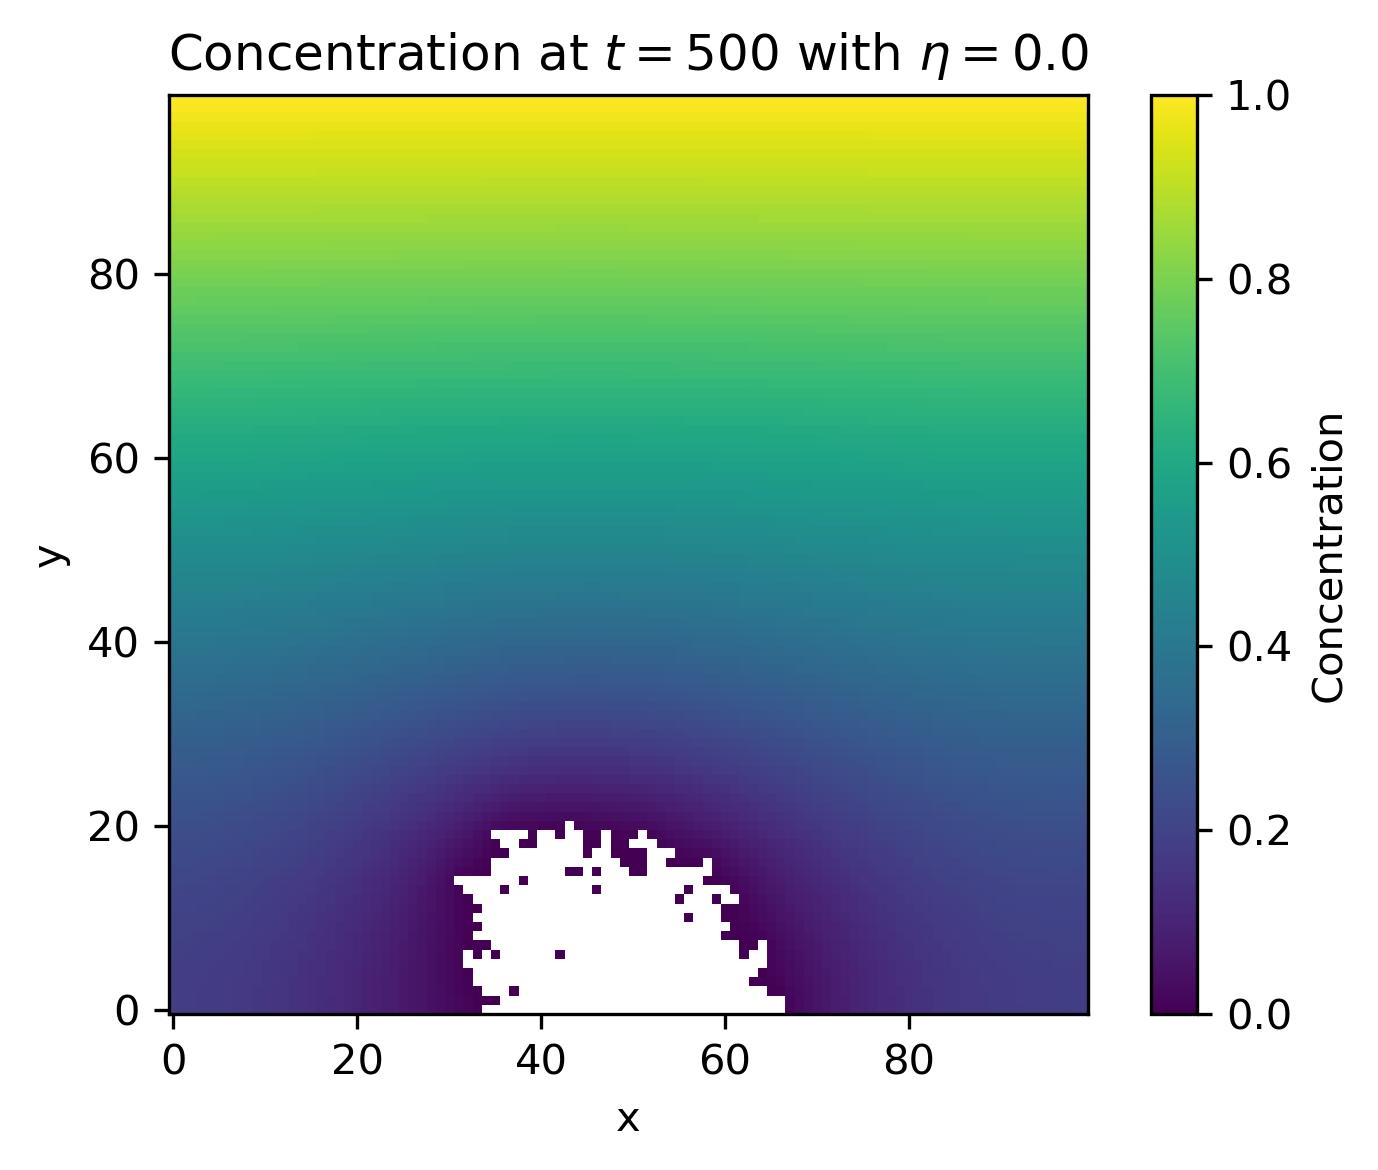

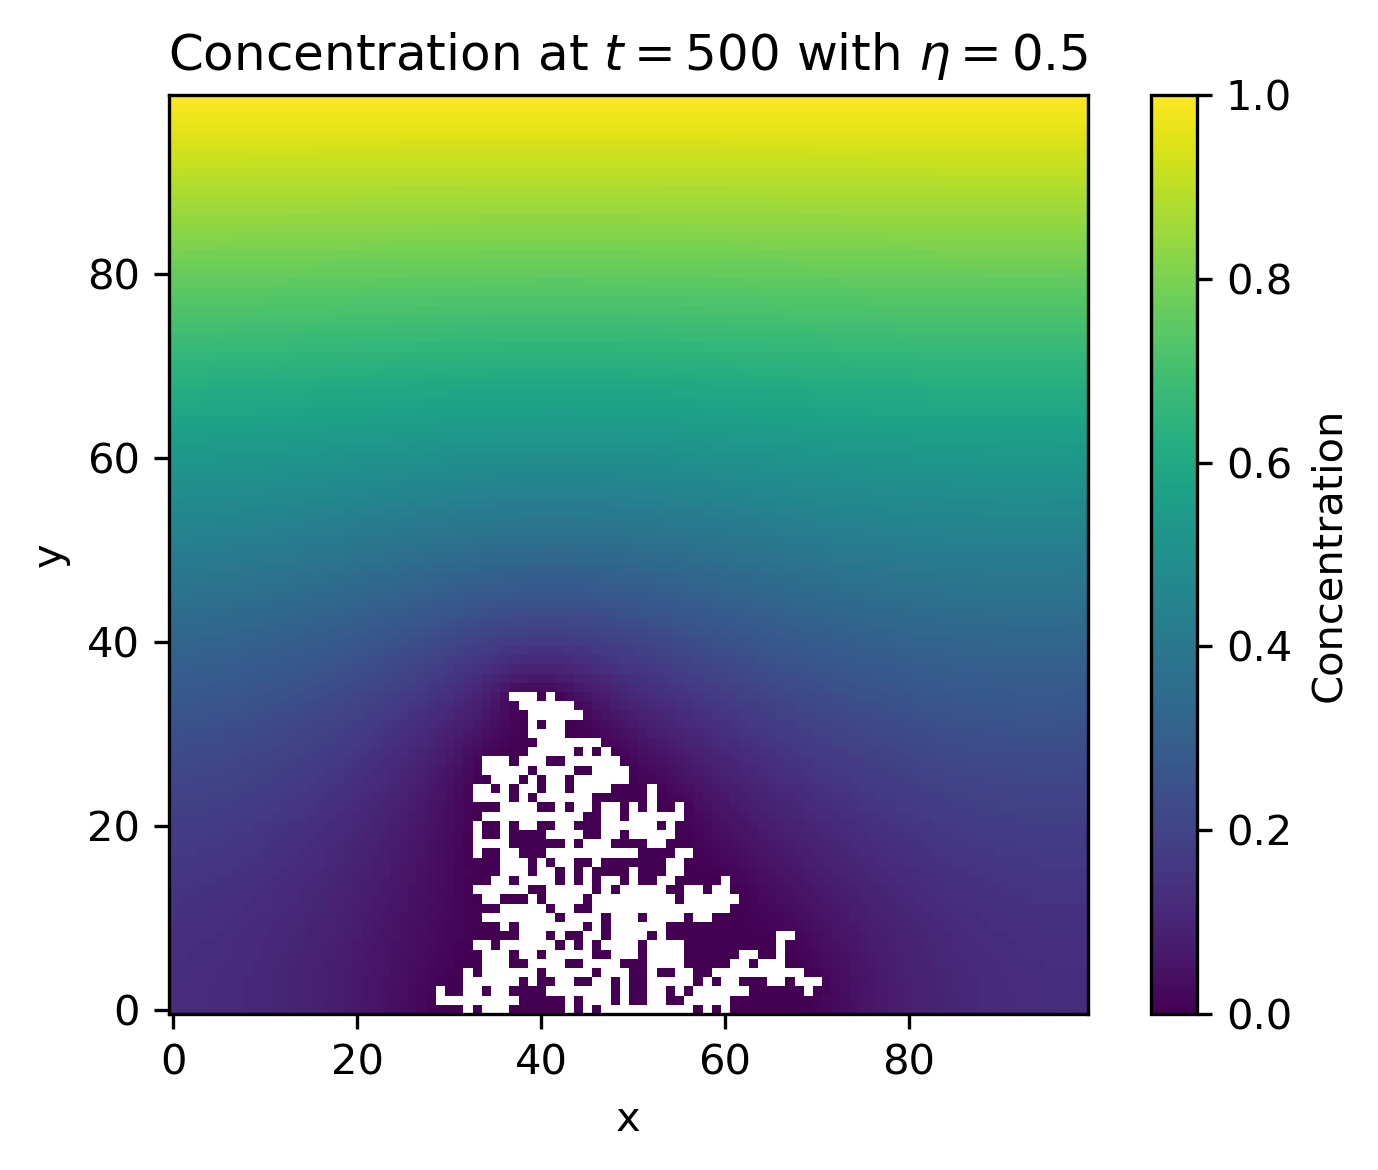

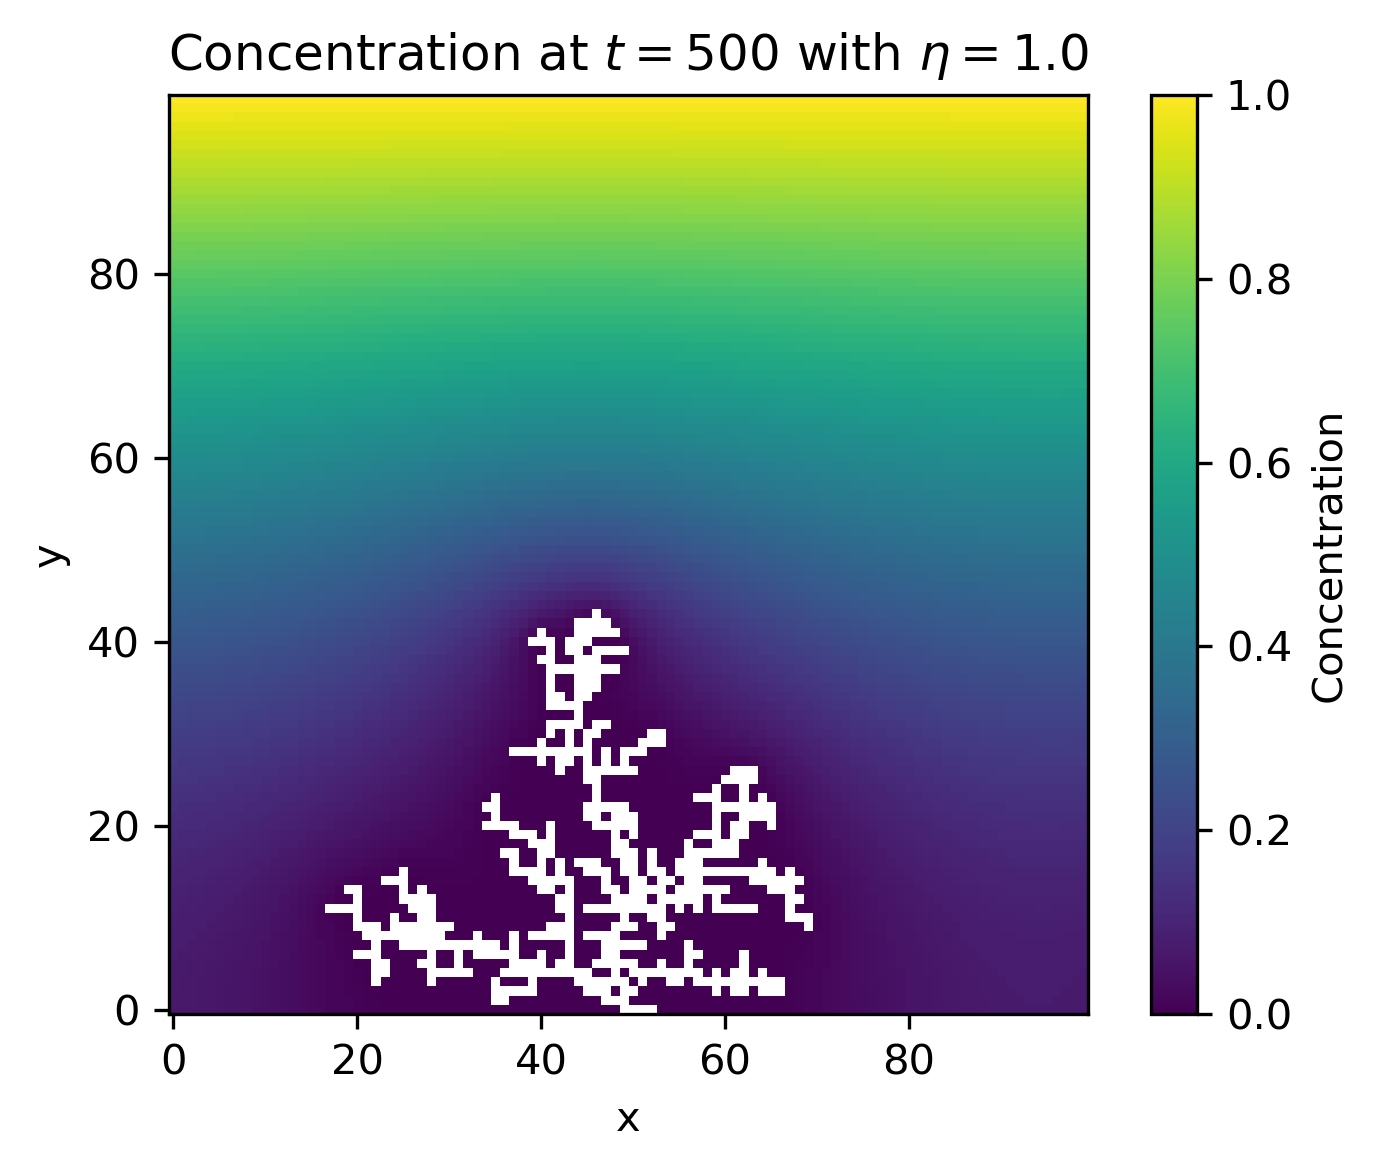

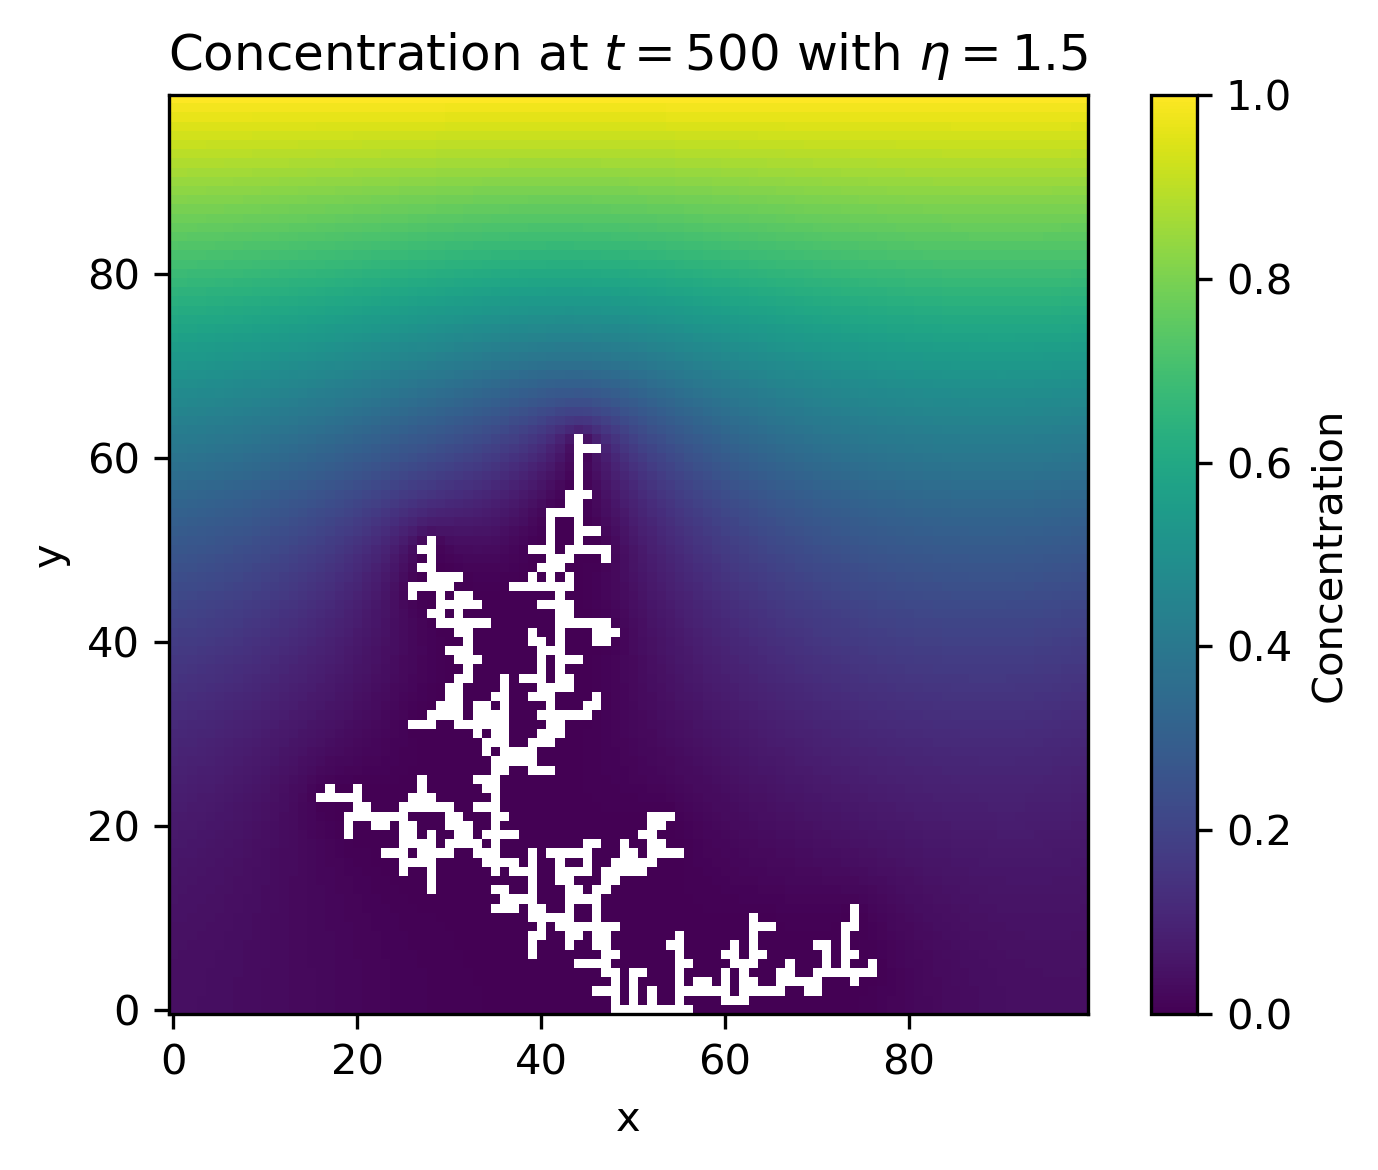

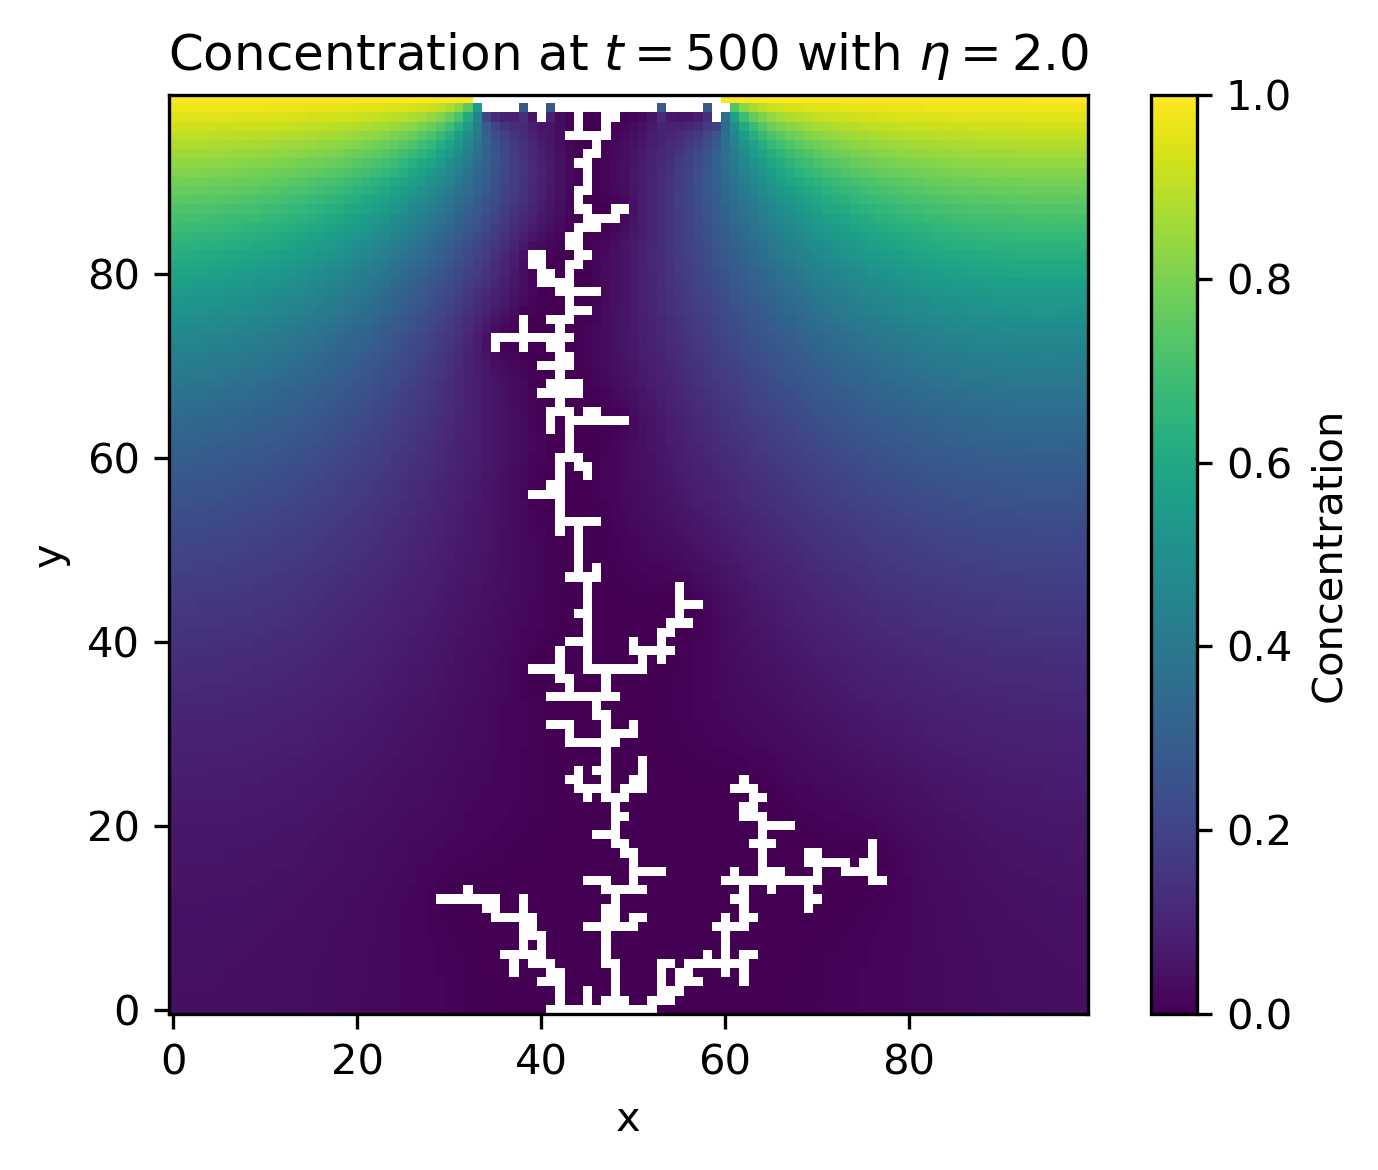

In [10]:
omega = 1.9
etas = [0.0, 0.5, 1.0, 1.5, 2.0]
Nt = 500
Nx = 100
max_sor_iter = 10_000

show_locally = []

for eta in tqdm(etas, desc='Simulating & plotting across eta range', leave=False, unit='sim'):
    title = f'Concentration at $t={Nt}$ with $\\eta = {eta}$'
    filename = f'final_concentration_dla_iters_{Nt}_iters_eta_{eta}'
    if LOAD_CACHED_FILES_IF_AVAILABLE and os.path.exists(f'{MEDIA_PATH}/{filename}.png'):
        show_locally.append(f'{MEDIA_PATH}/{filename}.png')
    else:
        c, obj, sor_iters, times = simulate_dla_growth_model(Nt=Nt, Nx=Nx, max_sor_iter=max_sor_iter, omega=omega, eta=eta, init_optimize=True)
        plot_object_on_concentration(c, obj, title, filename)

for path in show_locally:
    display(Image(filename=path, width=450))

# Choice of $\omega$ parameter for SOR performance

Calculation of time/iterations needed for SOR averaged across $N$ runs. Load if already calculated and saved prior for selected $N$

In [11]:
omegas = np.concatenate((np.linspace(1.0, 1.9, 10), np.array([1.95])))
eta = 1.0
Nt = 250
Nx = 100
max_sor_iter = 50_000 # increase max iterations to enable suboptimal omegas to convergence
N = 25 # number of runs to average over

times_file_mean = f'{DATA_PATH}/omega_{N}_runs_{Nt}_iters_times.csv'
sor_iters_file_mean = f'{DATA_PATH}/omega_{N}_runs_{Nt}_iters_sor_iters.csv'

nd_times_mean = np.zeros((len(omegas), Nt))
nd_sor_iters_mean = np.zeros((len(omegas), Nt))

if LOAD_CACHED_FILES_IF_AVAILABLE and os.path.exists(times_file_mean) and os.path.exists(sor_iters_file_mean):
    nd_times_mean = np.loadtxt(times_file_mean, delimiter=',')
    nd_sor_iters_mean = np.loadtxt(sor_iters_file_mean, delimiter=',')
else:
    pbar = tqdm(enumerate(omegas), total=len(omegas)*N, desc='Simulating across omega ranges', unit='sim', leave=False)
    for i, omega in pbar:
        acc_sor_iters = np.zeros((Nt, N))
        acc_times = np.zeros((Nt, N))
        for _ in range(N):
            c, obj, sor_iters, times = simulate_dla_growth_model(Nt=Nt, Nx=Nx, max_sor_iter=max_sor_iter, omega=omega, eta=eta, init_optimize=True, show_tqdm=False)
            acc_sor_iters[:, i] = sor_iters
            acc_times[:, i] = times
            pbar.update(1)
        mean_sor_iters = np.mean(acc_sor_iters, axis=1)
        mean_times = np.mean(acc_times, axis=1)
        log.debug(f'Mean iters for run: {mean_sor_iters}')
        log.debug(f'Mean times for run: {mean_times}')
        nd_times_mean[i] = mean_times
        nd_sor_iters_mean[i] = mean_sor_iters

    # Save the arrays to the files
    omega_str = ','.join([f'omega_{o:.2f}' for o in omegas])
    np.savetxt(times_file_mean, nd_times_mean, delimiter=',')
    np.savetxt(sor_iters_file_mean, nd_sor_iters_mean, delimiter=',')


Visualize results

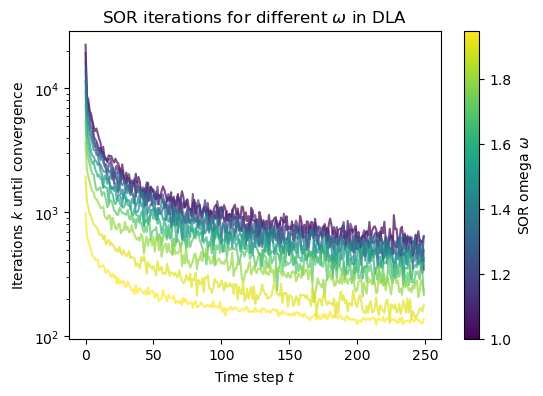

In [12]:
t = np.arange(Nt)

# For plotting purposes
nd_sor_iters_mean[nd_sor_iters_mean == 0] = np.nan

fig, ax = plt.subplots(figsize=(6, 4))
cmap_walkers = plt.get_cmap('viridis')
norm = Normalize(vmin=omegas.min(), vmax=omegas.max())

for i, omega in enumerate(omegas):
    color = cmap_walkers(norm(omega))
    ax.plot(t, nd_sor_iters_mean[i, :], color=color, alpha=0.7)

ax.set_xlabel('Time step $t$')
ax.set_ylabel('Iterations $k$ until convergence')
ax.set_yscale('log')

# Colorbar mapping
sm = ScalarMappable(cmap=cmap_walkers, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='SOR omega $\\omega$')

ax.set_title(f'SOR iterations for different $\\omega$ in DLA')
fig.savefig(f'{MEDIA_PATH}/omega_iterations_{N}_samples.png', dpi=300, bbox_inches='tight')
plt.show()

# 2.1.2 - Random Walker Growth Simulation

Handle the new logging

In [13]:
fh.close()
fh = FileHandler(f'{LOG_PATH}/ex2_1_2.log', mode='w', level=WARNING, bubble=True)
fh.push_application()

Utility functions for simulating random walkers in large numbers using array operations. Useful code base for conversion to GPU-based processing version.

In [36]:
def init_grid(Nx=100, seed_pos='lower center'):
    '''Initializes the object grid with seed at specified location'''
    obj_grid = np.zeros((Nx, Nx))
    seed_pos_idx = get_seed_position(Nx, seed_pos)
    log.info(f'Seed position: {seed_pos_idx}')
    obj_grid[*seed_pos_idx] = 1
    return obj_grid

def get_possible_steps(neighborhood='von_neumann'):
    '''Returns the possible steps for the walkers based on the neighborhood type'''
    possible_steps = None
    if neighborhood == 'von_neumann':
        possible_steps = np.array([(1, 0), (0, 1), (-1, 0), (0, -1)])
    elif neighborhood == 'moore':
        possible_steps = np.array([(1, 0), (0, 1), (-1, 0), (0, -1), (1, 1), (-1, 1), (1, -1), (-1, -1)])
    else:
        log.error('Unsupported neighborhood type. Using von Neumann instead.')
        possible_steps = np.array([(1, 0), (0, 1), (-1, 0), (0, -1)])
    return possible_steps

def spawn_walkers(n_walkers, Nx):
    '''Spawns walkers at the top of the grid'''
    x = np.random.choice(Nx, size=n_walkers, replace=True)
    log.debug(f'Spawning walkers at x = {x}')
    return [[x[i], Nx-1] for i in range(n_walkers)]


def walkers_step_iterative(walkers, possible_steps, obj_grid, Nx):
    '''Steps the walkers based on the possible steps and the object grid. Iterative solution (less performant).'''
    remove_walkers = []
    
    for i, walker in enumerate(walkers):
        x, y = walker
        step_x, step_y = random.choice(possible_steps)
        candidate_pos = ((x + step_x) % Nx, y + step_y) # periodic boundary in x

        if candidate_pos[1] > Nx-1 or candidate_pos[1] < 0:  # Walks out of grid in y
            log.debug(f'Walker attempted to move out of grid to {candidate_pos}. Removing walker.')
            remove_walkers.append(walker)
            continue
        try:
            if obj_grid[candidate_pos] == 1: # Trying to move to occupied site
                log.debug(f'Walker attempted to step on occupied site at {candidate_pos}. Leaving it be.')
                continue
        except IndexError: # Somehow still trying to move out of the grid
            log.error(f'Walker attempted to move out of grid to {candidate_pos}. This attempt should not be possible.')
            remove_walkers.append(walker)
            continue

        walkers[i] = candidate_pos

    for walker in remove_walkers:
        walkers.remove(walker)

    return walkers

def walkers_step(walkers, possible_steps, obj_grid, Nx):
    '''Steps the walkers based on the possible steps and the object grid. Vectorized solution (more performant, especially at scale).'''
    walkers = np.array(walkers)

    step_indices = np.random.choice(len(possible_steps), size=len(walkers), replace=True)
    steps = possible_steps[step_indices]

    candidate_positions = walkers + steps
    candidate_positions[:, 0] %= Nx # periodic boundary in x

    # Not walked out in y
    walkers_in_grid = (candidate_positions[:, 1] < Nx) & (candidate_positions[:, 1] >= 0)
    # Not walked onto occupied site
    walkers_on_occupied_tiles = np.zeros(len(walkers), dtype=bool) 
    walkers_on_occupied_tiles[walkers_in_grid] = obj_grid[candidate_positions[walkers_in_grid, 0], candidate_positions[walkers_in_grid, 1]] != 1

    valid_moves = walkers_on_occupied_tiles
    walkers[valid_moves] = candidate_positions[valid_moves]
    # Return valid walkers back
    return walkers[valid_moves].tolist()

def walkers_attempt_join_cluster_iterative(walkers, obj_grid, Nx, sticky_p=1.0):
    '''Walkers probabilistically attempt to attach/join the object. Iterative solution (less performant).'''
    remove_walkers = []
    for i, walker in enumerate(walkers):
        x, y = walker
        if obj_grid[*walker] == 1:
            log.info(f'Walker is on occupied site at {x},{y}. Removing walker.')
            remove_walkers.append(walker)
            log.debug(f'Walker count: {len(walkers)}')
            continue
        if y == 0:
            neighbors = obj_grid[x - 1, y] + obj_grid[(x + 1) % Nx, y] + obj_grid[x, y + 1]
        elif y == Nx-1:
            neighbors = obj_grid[x - 1, y] + obj_grid[(x + 1) % Nx, y] + obj_grid[x, y - 1]
        else:
            neighbors = obj_grid[x - 1, y] + obj_grid[(x + 1) % Nx, y] + obj_grid[x, y + 1] + obj_grid[x, y - 1]

        if neighbors > 0:
            log.debug(f'Walker at {walker} has {neighbors} neighbors. Attempting to join object.')
            p = np.random.uniform()
            if p < sticky_p:
                obj_grid[*walker] = 1
                log.info(f'Walker joining object at {walker}. Object size: {np.sum(obj_grid)}')
                remove_walkers.append(walker)
                log.debug(f'Walker count: {len(walkers)}')

    for walker in remove_walkers:
        walkers.remove(walker)

    return walkers, obj_grid

def walkers_attempt_join_cluster(walkers, obj_grid, possible_steps, Nx, sticky_p=1.0):
    '''Walkers probabilistically attempt to attach/join the object. Vectorized solution (more performant, especially at scale).'''
    N_walkers = len(walkers)

    if N_walkers == 0:
        return walkers, obj_grid
    
    walkers = np.array(walkers)
    
    # Remove walkers on occupied sites
    valid_walkers = obj_grid[walkers[:, 0], walkers[:, 1]] != 1
    walkers = walkers[valid_walkers]

    # Get neighbors of the walkers
    x, y = walkers.T

    neighbor_sum = np.zeros(len(walkers))
    for s_x, s_y in possible_steps:
        x_neighbor = (x + s_x) % Nx
        y_neighbor = np.clip(y + s_y, 0, Nx - 1)
        neighbor_sum += obj_grid[x_neighbor, y_neighbor]

    # Attempt to join the object
    p = np.random.uniform(size=len(walkers))
    successfully_join = p < (sticky_p * neighbor_sum)
    walkers_to_join = walkers[successfully_join]

    if np.sum(neighbor_sum > 0) > 0:
        log.debug(f'From {np.sum(neighbor_sum > 0)} walkers with neighbors, {len(walkers_to_join)} joined the object.')  
        
    obj_grid[walkers_to_join[:, 0], walkers_to_join[:, 1]] = 1

    # Remove walkers that joined the object
    walkers = walkers[~successfully_join]

    return walkers.tolist(), obj_grid

Core simulation functionality

In [37]:
def simulate_with_random_walkers(Nx=100, T_MAX=1_000, spawn_rate=1, max_walkers=50, sticky_p=1.0, neighborhood='von_neumann', seed_pos='lower center', return_history=False, return_history_every=250, terminate_at=None, show_tqdm=True):
    '''Spawns random walkers at a constant rate (spawn_rate per time iteration) and simulates their random walk through the grid for T iterations.
    Random walkers are removed if they leave the grid or if they attach to the growth object (with probability sticky_p).'''
    obj_grid = init_grid(Nx=Nx, seed_pos=seed_pos)
    walkers = []
    possible_steps = get_possible_steps(neighborhood=neighborhood)

    obj_grid_history = []
    walkers_history = []

    iterator = tqdm(range(T_MAX), desc='Simulating walkers through time', leave=False, position=0, file=sys.stdout) if show_tqdm else range(T_MAX)
    for t in iterator:
        log.debug(f'Simulating random walk at t={t}')
        if len(walkers) < max_walkers:
            spawn_n_walkers = min(spawn_rate, max_walkers - len(walkers))
            new_walkers = spawn_walkers(n_walkers=spawn_n_walkers, Nx=Nx)
            log.debug(f'{spawn_n_walkers} walkers spawned at t={t} at positions {new_walkers}')
            walkers += new_walkers
            log.debug(f'New walker count: {len(walkers)}')
        
        walkers = walkers_step(walkers, possible_steps, obj_grid, Nx)
        log.debug(f'Walker count: {len(walkers)}')
        
        walkers, obj_grid = walkers_attempt_join_cluster(walkers, obj_grid, possible_steps, Nx, sticky_p)
        log.debug(f'Walker count: {len(walkers)}')

        if return_history and t % return_history_every == 0:
            obj_grid_history.append(obj_grid.copy())
            walkers_history.append(walkers.copy())

        if terminate_at == 'reach_top' and np.any(obj_grid[:, Nx-1]) == 1:
            log.info(f'Object reached top of grid at t={t}. Terminating simulation.')
            break
        elif terminate_at is not None:
            # Interpret it as an integer
            terminate_at_size = int(terminate_at)
            if np.sum(obj_grid) >= terminate_at_size:
                log.info(f'Object reached max size of {terminate_at_size} at t={t}. Terminating simulation.')
                break
    
    if return_history:
        if t % return_history_every != 0:
            obj_grid_history.append(obj_grid.copy())
            walkers_history.append(walkers.copy())
        return obj_grid, walkers, t, obj_grid_history, walkers_history
    else:
        return obj_grid, walkers, t

Visualization functionality

In [38]:
DEEP_BLUE = (4/255, 23/255, 60/255)
CORAL = (255/255, 111/255, 97/255)
LIGHT_GREY = (0.7, 0.7, 0.7)
cmap_coral = LinearSegmentedColormap.from_list("ocean_coral", [DEEP_BLUE, CORAL])

def plot_object_with_walkers(obj, walkers, title, filename, save=True, cmap_coral=cmap_coral):
    '''Plots the object using provided colormap and the walkers in grey.'''
    plt.figure(figsize=(5, 4), layout='tight')
    alpha = (0.7,)

    walkers_grid = np.zeros_like(obj)
    for x, y in walkers:
        walkers_grid[x, y] = 1
    img = cmap_coral(np.rot90(obj, 3))
    img[np.rot90(walkers_grid, 3) == 1] = LIGHT_GREY + alpha

    plt.imshow(img, origin='lower')
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    if save:
        plt.savefig(f'{MEDIA_PATH}/{filename}.png', dpi=300, bbox_inches='tight')
    plt.show()

def animate_object_with_walkers(obj_grid_snapshots, walkers_snapshots, title, filename, save=True, cmap_coral=cmap_coral):
    '''Animates the object grid with walkers over time using provided colormap.'''
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.set_title(f'{title} at $t=0$')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    alpha = (0.7,)

    obj_grid_frames = obj_grid_snapshots
    walkers_frames = walkers_snapshots

    def anim_frame(i):
        ax.clear()
        
        obj = obj_grid_frames[i]
        walkers_grid = np.zeros_like(obj)
        for x, y in walkers_frames[i]:
            walkers_grid[x, y] = 1
        img = cmap_coral(np.rot90(obj, 3))
        img[np.rot90(walkers_grid, 3) == 1] = LIGHT_GREY  + alpha
        ax.imshow(img, origin='lower')
        
        ax.set_title(f'{title}')
        ax.set_xlabel('x')
        ax.set_ylabel('y')

    ani = anim.FuncAnimation(fig, anim_frame, frames=len(obj_grid_frames), interval=17, repeat=False)
    if save:
        ani.save(f'{MEDIA_PATH}/{filename}.mp4', fps=60, writer=ANIM_BACKEND, bitrate=1800)
    
    plt.close(fig)

Generating various growth objects of a set size for visual inspection and as samples

Simulating walkers through time:   0%|          | 0/1000000 [00:00<?, ?it/s]

[2024-03-13 14:50:10.298207] WARNING: Set 2 Logger: Object reached max size of 300 at t=918000. Terminating simulation.


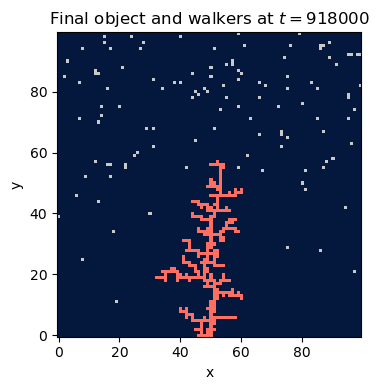

In [18]:
Nx = 100
T_MAX = 1_000_000
spawn_rate = 1
max_walkers = Nx*Nx*0.1 # max 10% of grid size
p_stickies = [0.05, 0.1, 0.25, 0.5, 0.75, 1.0]
terminate_at = '300' # object size to terminate at

for p_sticky in p_stickies:
    final_obj, final_walkers, iters, obj_grid_snapshots, walkers_snapshots = simulate_with_random_walkers(Nx=Nx, T_MAX=T_MAX, spawn_rate=spawn_rate, max_walkers=max_walkers, sticky_p=p_sticky, return_history=True, terminate_at=terminate_at)
    plot_object_with_walkers(final_obj, final_walkers, f'Final object and walkers at $t={iters}$', f'final_object_and_walkers_at_t={iters}_p={p_sticky}_terminate_at_{terminate_at}', save=True)
    animate_object_with_walkers(obj_grid_snapshots, walkers_snapshots, 'Random walkers creating object', f'random_walkers_creating_object_upto_t={iters}_p={p_sticky}_terminate_at_{terminate_at}', save=True)

Generating mean object shapes for three selected sticking probabilities to compare shapes of the resulting objects

Simulating many runs across sticky probabilities:   0%|          | 0/150 [00:00<?, ?sim/s]

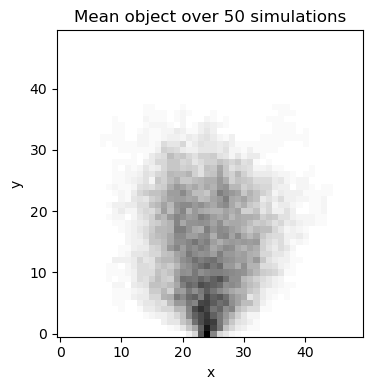

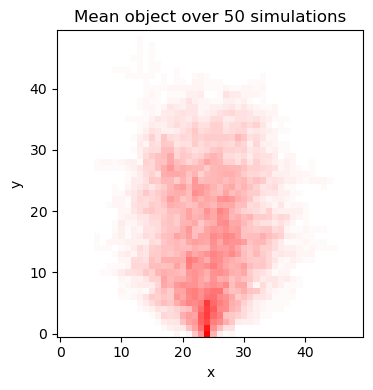

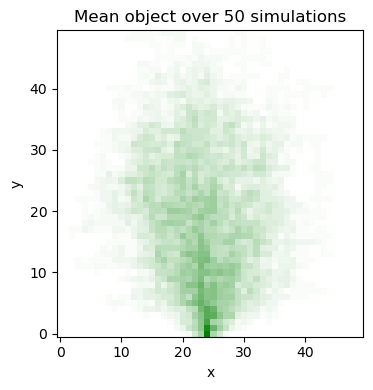

In [42]:
Nx = 50
T_MAX = 1_000_000
N_SIMS = 250
spawn_rate = 1
max_walkers = int(Nx*Nx*0.1)
p_stickies = [0.05, 0.5, 1.0]
terminate_at = '450' # object size to terminate at
cmaps = [LinearSegmentedColormap.from_list("ocean_coral", ["white", "black"]),
         LinearSegmentedColormap.from_list("ocean_coral", ["white", "red"]),
         LinearSegmentedColormap.from_list("ocean_coral", ["white", "green"])]

pbar = tqdm(total=len(p_stickies)*N_SIMS, desc='Simulating many runs across sticky probabilities', leave=False, unit='sim')
for p_sticky, cmap in zip(p_stickies, cmaps):
    mean_obj = np.zeros((Nx, Nx))
    for n in range(N_SIMS):
        final_obj, final_walkers, iters, obj_grid_snapshots, walkers_snapshots = simulate_with_random_walkers(Nx=Nx, T_MAX=T_MAX, spawn_rate=spawn_rate, max_walkers=max_walkers, sticky_p=p_sticky, return_history=True, terminate_at=terminate_at, show_tqdm=False)
        mean_obj += final_obj
        pbar.update(1)
    mean_obj /= N_SIMS

    # Plot mean object
    plot_object_with_walkers(mean_obj, [], f'Mean object over {N_SIMS} simulations', f'mean_object_p={p_sticky}_terminate_at_{terminate_at}_grid_{Nx}_N_{N_SIMS}', save=True, cmap_coral=cmap)

### 1.3 The Gray-Scott model - A reaction-diffusion system

In [ ]:
np.random.seed(42)
SAVE_PATH = 'media/ex2'
ANIM_BACKEND = 'ffmpeg'
os.makedirs(SAVE_PATH, exist_ok=True)

In [ ]:
def initialize_system(size=100):
    U = np.ones((size, size)) * 0.5
    V = np.zeros((size, size))
    
    square_size = size//5
    square_start = size // 2 - square_size // 2
    square_end = square_start + square_size
    V[square_start:square_end, square_start:square_end] = 0.25
    
    U += np.random.normal(0, 0.05, (size, size))
    V += np.random.normal(0, 0.05, (size, size))
    
    return U, V

@jit()
def update(u, v, Du, Dv, dt=1, dx=1):
    U_init = np.copy(u)
    V_init = np.copy(v)
    N = len(u)
    for i in range(N):
        for j in range(N):
            i_next = i + 1 if i < N - 1 else 0
            i_prev = i - 1 if i > 0 else N - 1
            j_next = j + 1 if j < N - 1 else 0
            j_prev = j - 1 if j > 0 else N - 1
            u[i, j] = U_init[i, j] + dt * (Du / dx ** 2 * (U_init[i_next, j] + U_init[i_prev, j] + U_init[i, j_next] + U_init[i, j_prev] - 4 * U_init[i, j]) - U_init[i, j] * V_init[i, j] ** 2 + f * (1 - U_init[i, j]))
            v[i, j] = V_init[i, j] + dt * (Dv / dx ** 2 * (V_init[i_next, j] + V_init[i_prev, j] + V_init[i, j_next] + V_init[i, j_prev] - 4 * V_init[i, j]) + U_init[i, j] * V_init[i, j] ** 2 - (f + k) * V_init[i, j])
    return u, v

def visualize(U, V, t, name=None):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
    u_plot = ax0.imshow(U, vmin=0, vmax=1)
    ax0.set_xlabel(r"$x$")
    ax0.set_ylabel(r"$y$")
    ax0.set_title(f'Concentration of u at t={t}')
    
    v_plot = ax1.imshow(V, vmin=0, vmax=1)
    ax1.set_title(f'Concentration of v at t={t}')
    ax1.set_xlabel(r"$x$")
    ax1.set_ylabel(r"$y$")

    fig.tight_layout()
    fig.colorbar(u_plot, ax=ax0)
    fig.colorbar(v_plot, ax=ax1)
    if name:
        plt.savefig(name, dpi=800)
    else: plt.show()

# Run the simulation
def run_simulation(U, V, Du, Dv, f, k, T=8000):
    for t in trange(T):
        U, V = update(U, V, Du, Dv)
    return U, V

100%|██████████| 5000/5000 [00:08<00:00, 624.16it/s]


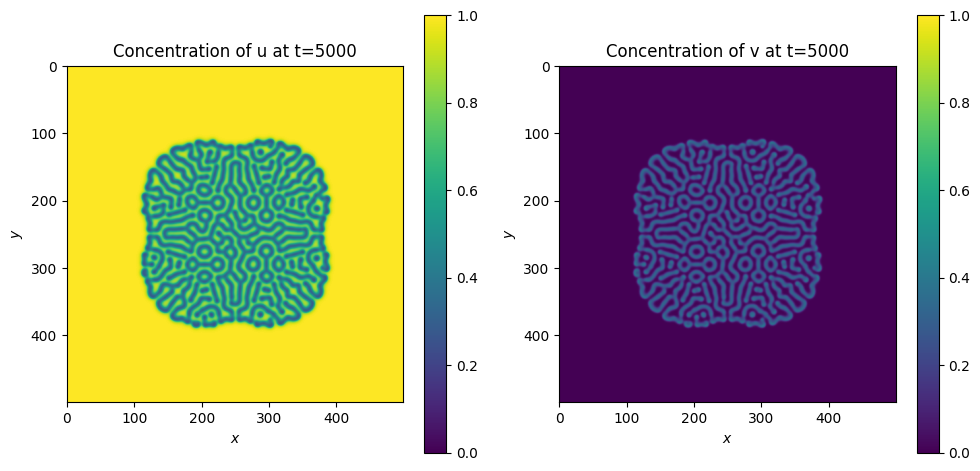

In [ ]:
end_time = 5_000
grid_size = 500
# Du, Dv = .1, .05
# F, k = 0.0545, 0.062
#Du, DV, F, k = 8.16 0.08, 0.035 0.965 Bacteria 1
# 3 #Du, DV, F, k = 8.14 0.06, 0.035 0.065Bacteria 2
# 4 #Du, Dv, F, k = 8.16 0.08, 0.068, Coral
# 5 #Du, Dv, F, K 0.19, 0.05, 0.060, 0.062 #Fingerprint
# 6 #Du, DV, F, 0.10, 0.018, 0.050 # Spirals
# Du, Dv, f, k = 0.12, 0.08, 0.020, 0.050 # Spirals Dense
# 9 #Du, Dv, F, k = 8.16 0.08 0.020, 0.055 # Unstable
# 16 #Du, Dv, F, K = 8.16 0.08, 0.050, 0.065 # Worms 1
# 11 #Du, Dv, F, K 8.16, 0.08, 0.054, 0.063 # Worms 2
# 12 #Du, Dv, F, K = 0.16, 0.08, 0.035, 0.060 # Zebrafish

U, V, = initialize_system(size=grid_size)
Du=0.16; Dv=0.08; f=0.035; k=0.060
U_end, V_end = run_simulation(U, V, Du, Dv, f, k, T=end_time)
visualize(U_end, V_end, t=end_time, name=f"media_2/init_plot_{end_time}.png")

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:08<00:00, 606.63it/s]


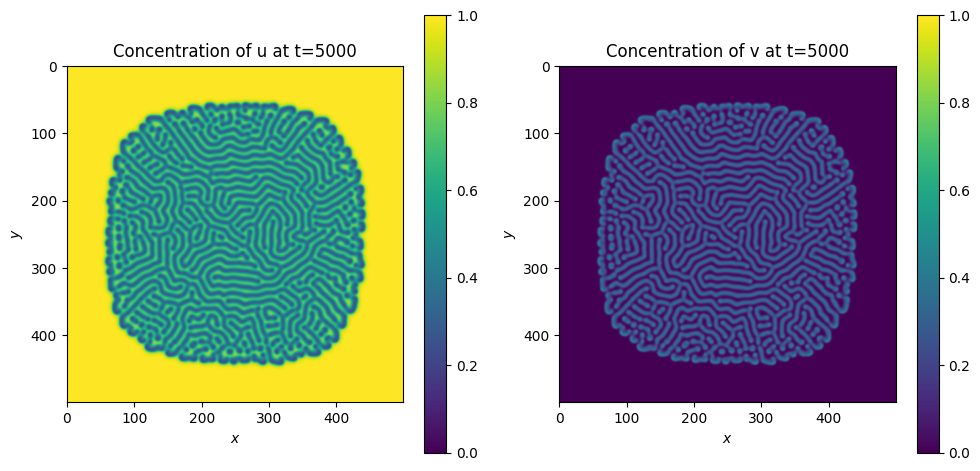

In [ ]:
# Different parameter
end_time = 5_000
grid_size = 500
U, V = initialize_system(size=grid_size)
Du=0.2; Dv=0.08; f=0.035; k=0.020  # Coral
U_end, V_end = run_simulation(U, V, Du, Dv, f, k, T=end_time)
visualize(U_end, V_end, t=end_time, name=f"media_2/coral_plot_{end_time}.png")

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:03<00:00, 552.24it/s]


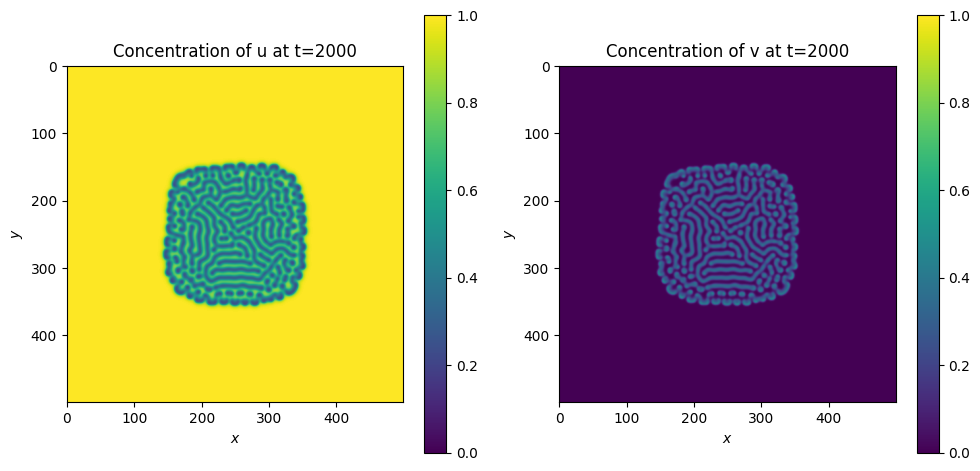

In [ ]:
# Different parameter
end_time = 2000
grid_size = 500
U, V = initialize_system(size=grid_size)
Du=0.2; Dv=0.08; f=0.01; k=0.05  # spiral
U_end, V_end = run_simulation(U, V, Du, Dv, f, k, T=end_time)
visualize(U_end, V_end, t=end_time, name=f"media_2/spiral_plot_{end_time}.png")

  0%|          | 0/2500 [00:00<?, ?it/s]

100%|██████████| 2500/2500 [00:04<00:00, 590.87it/s]


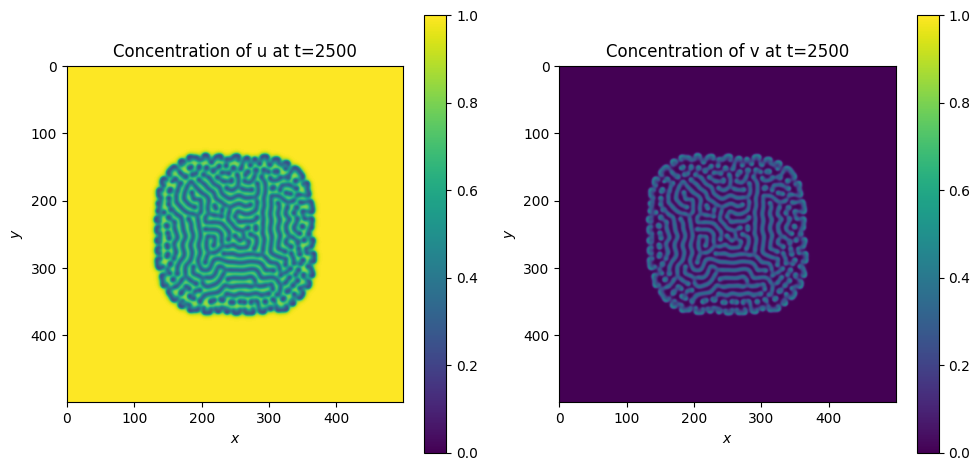

In [ ]:
# Different parameter
end_time = 2500
grid_size = 500
U, V = initialize_system(size=grid_size)
Du=0.2; Dv=0.08; f=0.04; k=0.0105  # spiral
U_end, V_end = run_simulation(U, V, Du, Dv, f, k, T=end_time)
visualize(U_end, V_end, t=end_time, name=f"media_2/dotted_plot_{end_time}.png")

In [ ]:
# Add an animate function
def animate(frame_num, U, V, Du, Dv, f, k, imU, imV):
    U, V = update(U, V, Du, Dv)
    imU.set_array(U)
    imV.set_array(V)
    print(frame_num, end="\r")
    return imU, imV,

# Set up the figure for animation
def setup_figure(U, V):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    imU = axs[0].imshow(U, vmin=0, vmax=1, animated=True)
    axs[0].title.set_text('Concentration of u')
    axs[0].axis('off')

    imV = axs[1].imshow(V, vmin=0, vmax=1, animated=True)
    axs[1].title.set_text('Concentration of v')
    axs[1].axis('off')
    fig.colorbar(imU, ax=axs[0])
    fig.colorbar(imV, ax=axs[1])
    

    # plt.tight_layout()
    return fig, imU, imV

# Running the simulation with animation
def run_simulation_with_animation(U, V, Du, Dv, f, k, T=800):
    fig, imU, imV = setup_figure(U, V)

    ani = FuncAnimation(fig, animate, frames=range(T), fargs=(U, V, Du, Dv, f, k, imU, imV), blit=True, interval=100)
    
    plt.show()
    return ani


In [ ]:
# Specified parameters in Set 2
grid_size = 300
end_time = 10_000
U, V = initialize_system(size=grid_size)
Du=0.16; Dv=0.08; f=0.035; k=0.060
# Du, Dv = .1, .05
# F, k = 0.0545, 0.062
ani = run_simulation_with_animation(U, V, Du, Dv, f, k, T=end_time)
ani.save("media/animation.mp4", writer="ffmpeg")

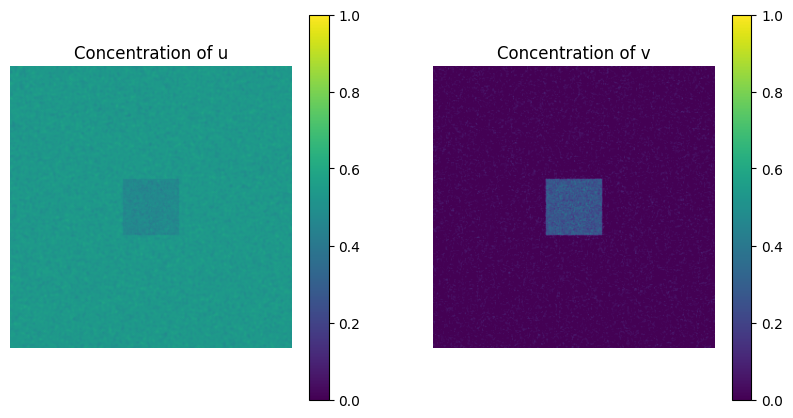

In [ ]:
# Altering model parameters
grid_size = 300
end_time = 10_000
U, V = initialize_system(size=grid_size)
Du=0.2; Dv=0.08; f=0.035; k=0.020
# Du=0.16; Dv=0.08; f=0.035; k=0.060
# Du, Dv = .1, .05
# F, k = 0.0545, 0.062
ani = run_simulation_with_animation(U, V, Du, Dv, f, k, T=end_time)
ani.save("media/coral_animation.mp4", writer="ffmpeg")